In [1]:
import warnings
warnings.filterwarnings('ignore')

import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

from IPython.display import HTML as html_print

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

In [ ]:
%%time
train = pd.read_pickle("data\\train_data")


Wall time: 11.9 s


In [ ]:
train.columns

Index(['acoustic_data', 'time_to_failure'], dtype='object')

In [ ]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


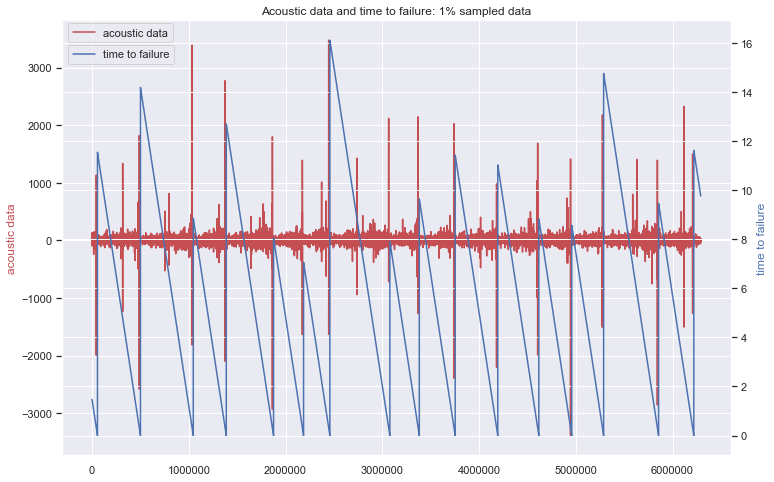

In [ ]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [ ]:


    
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()

    
    for windows in [10,100,300,600]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_train.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_train.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_train.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_train.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_train.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()      
        X_train.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_train.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_train.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_train.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_train.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_train.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_train.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    


 14%|█▍        | 588/4194 [01:50<11:05,  5.42it/s]

In [ ]:
type(X_train)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))

In [ ]:
#X_train = pd.DataFrame(X_train)

In [ ]:
X_train.columns

In [ ]:
y_train.columns

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train_scaled.shape))

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)


In [ ]:
lm = LinearRegression()

In [ ]:
lm.fit(X_train_scaled,y_train)

In [ ]:
# The coefficients
print('Coefficients: \n', lm.coef_)

In [ ]:
predictions = lm.predict(X_train_scaled)

In [ ]:


score = mean_absolute_error(y_train.values.flatten(), predictions)
print(f'Score: {score:0.3f}')



In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_train, predictions))
print('MSE:', metrics.mean_squared_error(y_train, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))

In [ ]:
plt.scatter(y_train,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [ ]:
submission = pd.read_csv('data\\sample_submission.csv', index_col='seg_id')

In [ ]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
i=0

In [ ]:
for seg_id in X_test.index:
    seg = pd.read_csv('test\\' + seg_id + '.csv')
    print("seg_id: ",seg_id)
    print("count test: ",i)
    i=i+1
    x = pd.Series(seg['acoustic_data'].values)
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    for windows in [10,100,300,600]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    
    



In [ ]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = lm.predict(X_test_scaled)
submission.to_csv('submission.csv')